# Growth media for the AGORA database

AGORA is a database targeting the gut microbiota. As such we already supplied a growth medium based on an average western diet. We will start from this medium to illustrate how we can inspect the performance of growth medium in a model database and how to supplement a medium to allow fro growth for all models.

The growth medium supllied here was created the following way:

1. start with the growty medium reported in https://doi.org/10.1038/nbt.4212
2. manually dilute all components absorbed in the small intestine (simple sugars, vitamins, amino acids, etc) 1:10 
3. add in mucin
4. deplete oxygen since the lower gut is mostly anaerobic

We can take a look by reading it using micom.

In [1]:
import pandas as pd
from micom.workflows.media import process_medium 

medium = pd.read_csv("../data/agora103_western_gut.csv", index_col=False)
medium = process_medium(medium, ["dummy"])
medium

,flux,dilution,metabolite,reaction,global_id,sample_id
reaction,,,,,,
EX_fru_m,0.014899,0.100,fru_m,EX_fru_m,EX_fru(e),dummy
EX_glc_m,0.014899,0.100,glc_m,EX_glc_m,EX_glc(e),dummy
EX_gal_m,0.014899,0.100,gal_m,EX_gal_m,EX_gal(e),dummy
EX_man_m,0.014899,0.100,man_m,EX_man_m,EX_man(e),dummy
EX_mnl_m,0.014899,0.100,mnl_m,EX_mnl_m,EX_mnl(e),dummy
...,...,...,...,...,...,...
EX_glu_D_m,0.100000,0.100,glu_D_m,EX_glu_D_m,EX_glu_D(e),dummy
EX_gthrd_m,0.100000,0.100,gthrd_m,EX_gthrd_m,EX_gthrd(e),dummy
EX_h2_m,0.100000,0.100,h2_m,EX_h2_m,EX_h2(e),dummy


The fluxes here are the already diluted amounts and denote the upper bound for the import (can be less). The dilution factors are kept here for the sake of reproducibility. 

## Checking the growth medium against the DB

But can the bacteria in our model database actually grow on this medium? Let's check and start by downbloading the AGORA model database.

In [2]:
# !wget https://zenodo.org/record/3755182/files/agora103_genus.qza?download=1 -O data/agora103_genus.qza

No we we will check for growth by running the growth medium against any single model.

In [3]:
from micom.workflows.db_media import check_db_medium

check = check_db_medium("../data/agora103_genus.qza", medium, threads=20)

Output()

`check` now includes the entire manifest plus two new columns: the growth rate and whether the models can grow.

In [4]:
check.can_grow.value_counts()

True    227
Name: can_grow, dtype: int64

All genera can grow.

(array([ 2.,  3.,  5.,  7., 13., 27., 77., 30., 21., 42.]),
 array([-3.40288095, -3.0992051 , -2.79552925, -2.4918534 , -2.18817754,
        -1.88450169, -1.58082584, -1.27714999, -0.97347414, -0.66979829,
        -0.36612243]),
 <BarContainer object of 10 artists>)

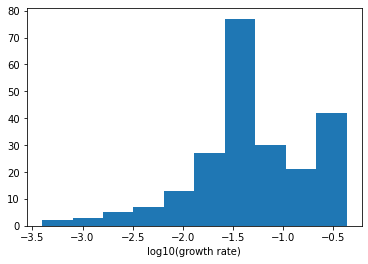

In [5]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

plt.xlabel("log10(growth rate)")
plt.hist(np.log10(check.growth_rate[check.can_grow])) 

We see the the smallest growth rate that can be reached is around 10^-5. Let's complete the medium so that all taxa in Refseq can grow at a rate of at least 10^-3.

## Supplementing a growth medium from a skeleton

Sometimes you may start from a few componenents and will want to complete this skeleton medium to reach a certain minimum growth rate across all models in the database. This can be done with `complete_db_medium`. By default this will minimize the added flux, but we will minimize the added total mass influx in order to avoid adding small aditional imports for very large (for instance starches) molecules.

In [6]:
from micom.workflows.db_media import complete_db_medium

manifest, imports = complete_db_medium("../data/agora103_genus.qza", medium, growth=0.001, threads=20, max_added_import=10, weights="mass")

Output()

`manifest` is the amended manifest as before and `imports` contains the used import fluxes for each model. A new column in the mnaifest also tells us how many import were added.

In [7]:
manifest.added.describe()

count    226.000000
mean       0.022124
std        0.239345
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: added, dtype: float64

So we added at max 3 metabolites to the imports and in most cases none (as the previous medium was already good). We can also have a look at the used imports across all models.

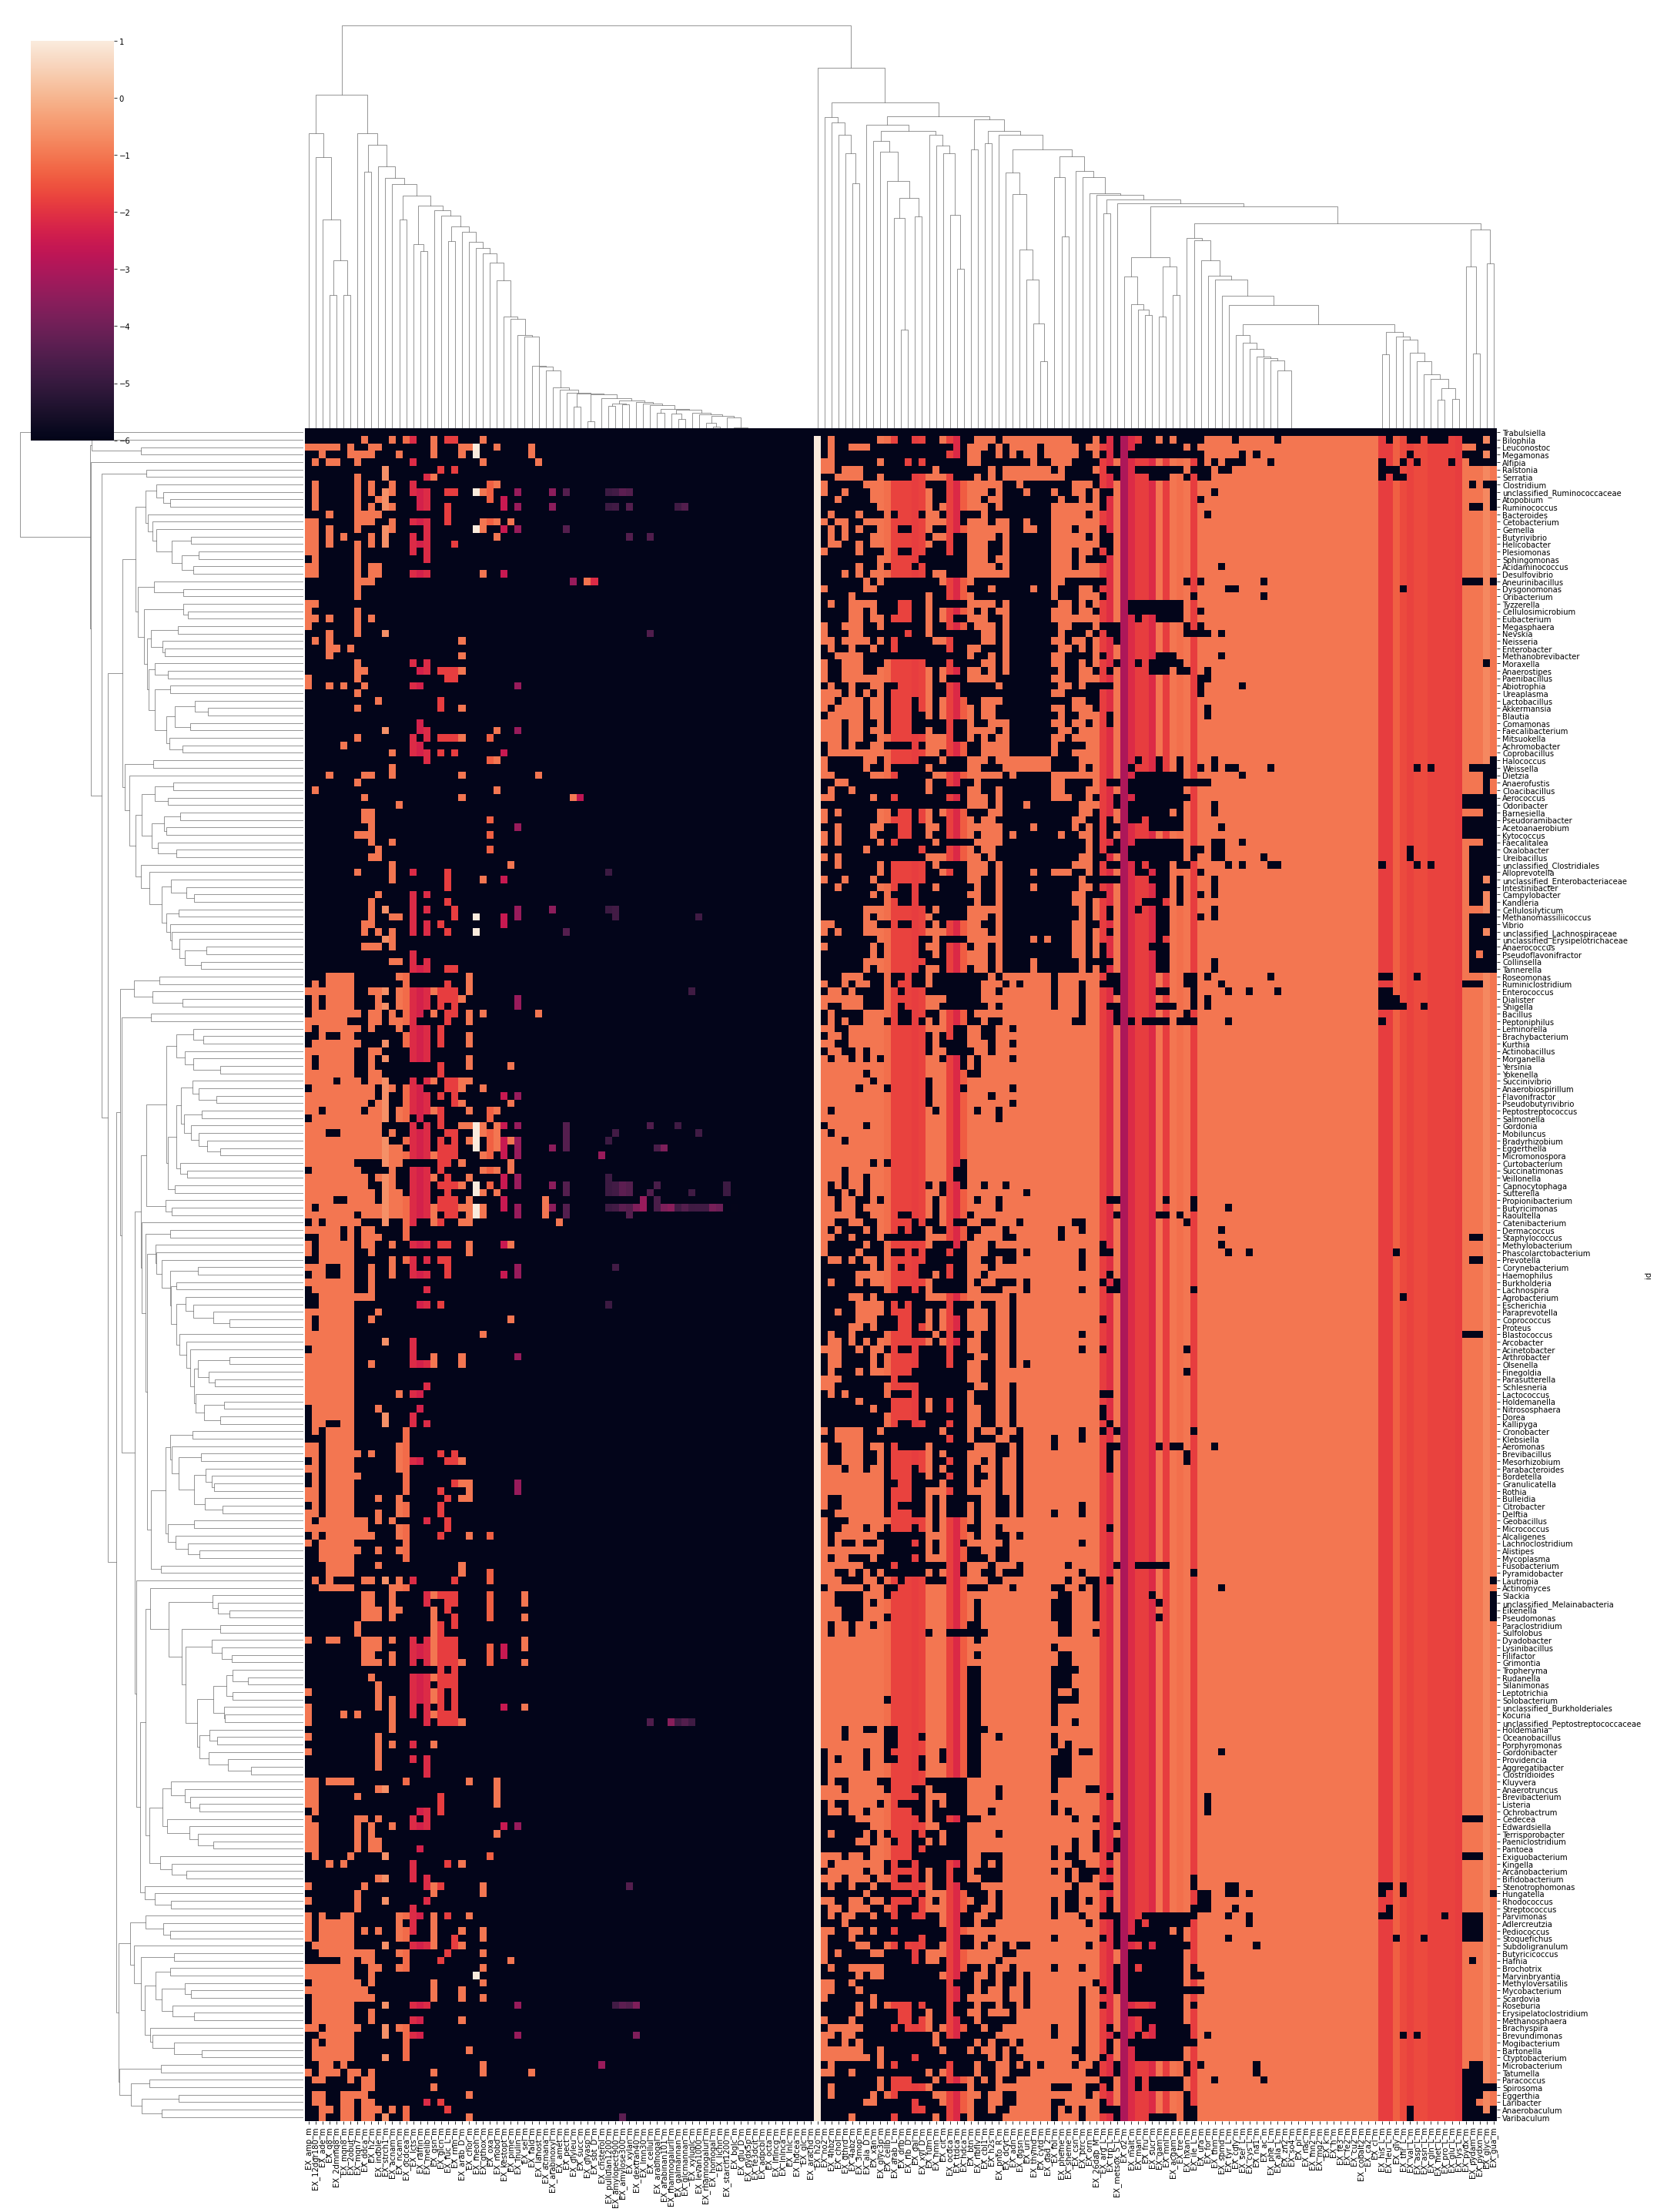

In [8]:
import seaborn as sns

sns.clustermap(np.log10(imports + 1e-6), xticklabels=True, yticklabels=True, figsize=(30, 40))

As we can see some metabolites are consumed by all taxa but there are also many taxa-specific ones. If you know you will only use a subset of the database you can use the `imports` matrix to design a new more minimal growth medium. For instance let's build a medium for only taxa from the Bacteroidetes phylum.

In [9]:
bacteroidetes = manifest[manifest.phylum == "Bacteroidetes"].id
bac_medium = imports.loc[bacteroidetes].max()
bac_medium = bac_medium[bac_medium > 1e-6]
bac_medium

EX_4abz_m             0.100000
EX_4hbz_m             0.100000
EX_ac_m               0.100000
EX_acgam_m            0.100000
EX_ala_L_m            0.100000
                        ...   
EX_xylan_m            0.000032
EX_rhamnogalurII_m    0.000267
EX_acmana_m           0.100000
EX_starch1200_m       0.000012
EX_sel_m              0.100000
Length: 148, dtype: float64

Finally lets also export the medium as Qiime 2 artifact which can be read with `q2-micom` or the normal micom package.

In [10]:
from qiime2 import Artifact

fluxes = imports.max()
fluxes = fluxes[(fluxes > 1e-6) | fluxes.index.isin(medium.reaction)]
completed = pd.DataFrame({
    "reaction": fluxes.index,
    "metabolite": fluxes.index.str.replace("^EX_", "", regex=True),
    "global_id": fluxes.index.str.replace("_m$", "(e)", regex=True),
    "flux": fluxes
})
completed.shape
completed.index = completed.reaction

arti = Artifact.import_data("MicomMedium[Global]", completed)
arti.save("../media/western_diet_gut_agora.qza")

'../media/western_diet_gut_agora.qza'

## Validation

And we validate that the new medium works.

In [11]:
check = check_db_medium("../data/agora103_genus.qza", completed, threads=20)
check.can_grow.value_counts()

Output()

True    227
Name: can_grow, dtype: int64

In [12]:
check.growth_rate.describe()

count    227.000000
mean       0.107486
std        0.123093
min        0.000891
25%        0.028599
50%        0.045764
75%        0.143464
max        0.479931
Name: growth_rate, dtype: float64

The minimum growth rate is a little lower than 0.001 due to numerical accuracy issues but it mostly fulfills the requirements we posed.